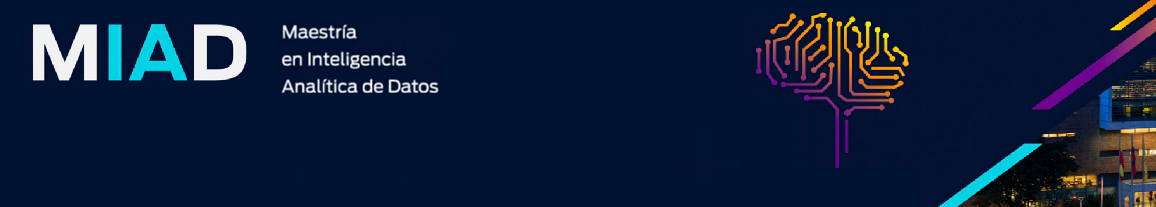

# Implementar un proceso ETL
---

## Instalar librerias

In [1]:
!pip install pyspark
!wget https://dev.mysql.com/get/Downloads/Connector-J/mysql-connector-java-8.0.26.tar.gz
!tar -xzf mysql-connector-java-8.0.26.tar.gz
!mv mysql-connector-java-8.0.26/mysql-connector-java-8.0.26.jar ./

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=f95fa0ef3fb987c88668028860290f7f32c533ac7c1af8974b398d9d7987ba7c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
--2024-07-19 04:34:05--  https://dev.mysql.com/get/Downloads/Connector-J/mysql-connector-java-8.0.26.tar.gz
Resolving dev.mysql.com (dev.mysql.com)... 23.222.161.234, 2600:1406:5800:3ac::2e31, 2600:1406:5800:39a::2e31
Connecting to dev.mysql.com (dev.mysql.com)|23.222.161.234|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://cdn.mysql.com//archives/mysql-connector-java-8.0/mysql-connector-java-8.0.26.tar.gz [following]
--2024-07-19 04:34:06--  https://cdn.mysql.com//archives/mysql-connector-java-8.0/mysql-connector-java-8.0.26.t

## Importar Librerias

In [2]:
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
import os
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as f, SparkSession, types as t
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.functions import udf, col, length, isnan, when, count, regexp_replace, expr
from datetime import datetime
from pyspark.sql.functions import dayofmonth, month, year, date_format, to_date, concat_ws, lpad, lit, substring, concat

import pandas as pd
from IPython.display import HTML
from functools import reduce
%matplotlib inline
import matplotlib.pyplot as plt

## Configuración conexión con el servidor:

In [3]:
path_jar_driver = '/content/mysql-connector-java-8.0.26.jar'

In [4]:
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver) \
    .set('spark.sql.legacy.timeParserPolicy', 'LEGACY')

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
source_db_connection_string = 'jdbc:mysql://157.253.236.120:8080/RaSaTransaccional_ETL'
dest_db_connection_string = 'jdbc:mysql://157.253.236.120:8080/Estudiante_3_202413'

db_user = 'Estudiante_3_202413'
db_psswd = 'aabb1122'
PATH = './'

## Conexión y carga de datos

In [6]:
def obterner_dataframe_desde_csv(_PATH, _sep):
    return spark.read.load(_PATH, format="csv", sep=_sep, inferSchema="true", header='true')

def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

def guardar_db(db_connection_string, df, tabla, db_user, db_psswd):
    df.select('*').write.format('jdbc') \
      .mode('append') \
      .option('url', db_connection_string) \
      .option('dbtable', tabla) \
      .option('user', db_user) \
      .option('password', db_psswd) \
      .option('driver', 'com.mysql.cj.jdbc.Driver') \
      .save()

In [7]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        # Contar valores nulos
        nulos = df.filter(col(c).isNull()).count()
        # Contar valores vacíos
        vacios = df.filter(col(c) == '').count()
        # Total de valores nulos y vacíos
        total_vacios = nulos + vacios
        if total_vacios != 0:
            print(f'Número de vacíos para columna {c}: {total_vacios}')
            resultados.append((c, total_vacios))
    return resultados

# Cargar Tablas de Base de Datos

In [8]:
# TABLA CRISTHIAN
areas_servicio = 'RaSaTransaccional_ETL.FuenteAreasDeServicio_ETL'
areas_servicio = obtener_dataframe_de_bd(source_db_connection_string, areas_servicio, db_user, db_psswd)
#TABLA LUIS
planes_beneficio = 'RaSaTransaccional_ETL.FuentePlanesBeneficio_ETL'
planes_beneficio = obtener_dataframe_de_bd(source_db_connection_string, planes_beneficio, db_user, db_psswd)
#TABLA LUISA
tipo_benef = 'RaSaTransaccional_ETL.FuenteTiposBeneficio_ETL'
tipo_benef = obtener_dataframe_de_bd(source_db_connection_string, tipo_benef, db_user, db_psswd)
#TABLA EDWIN
condiciones_pago = 'RaSaTransaccional_ETL.FuenteCondicionesDePago_ETL'
condiciones_pago = obtener_dataframe_de_bd(source_db_connection_string, condiciones_pago, db_user, db_psswd)

# Creación de Tablas y Proceso ETL
---
Teniendo en cuenta el esquema suministrado se realiza el proceso ETL para las diferentes tablas requeridas para el analisis



![image.png](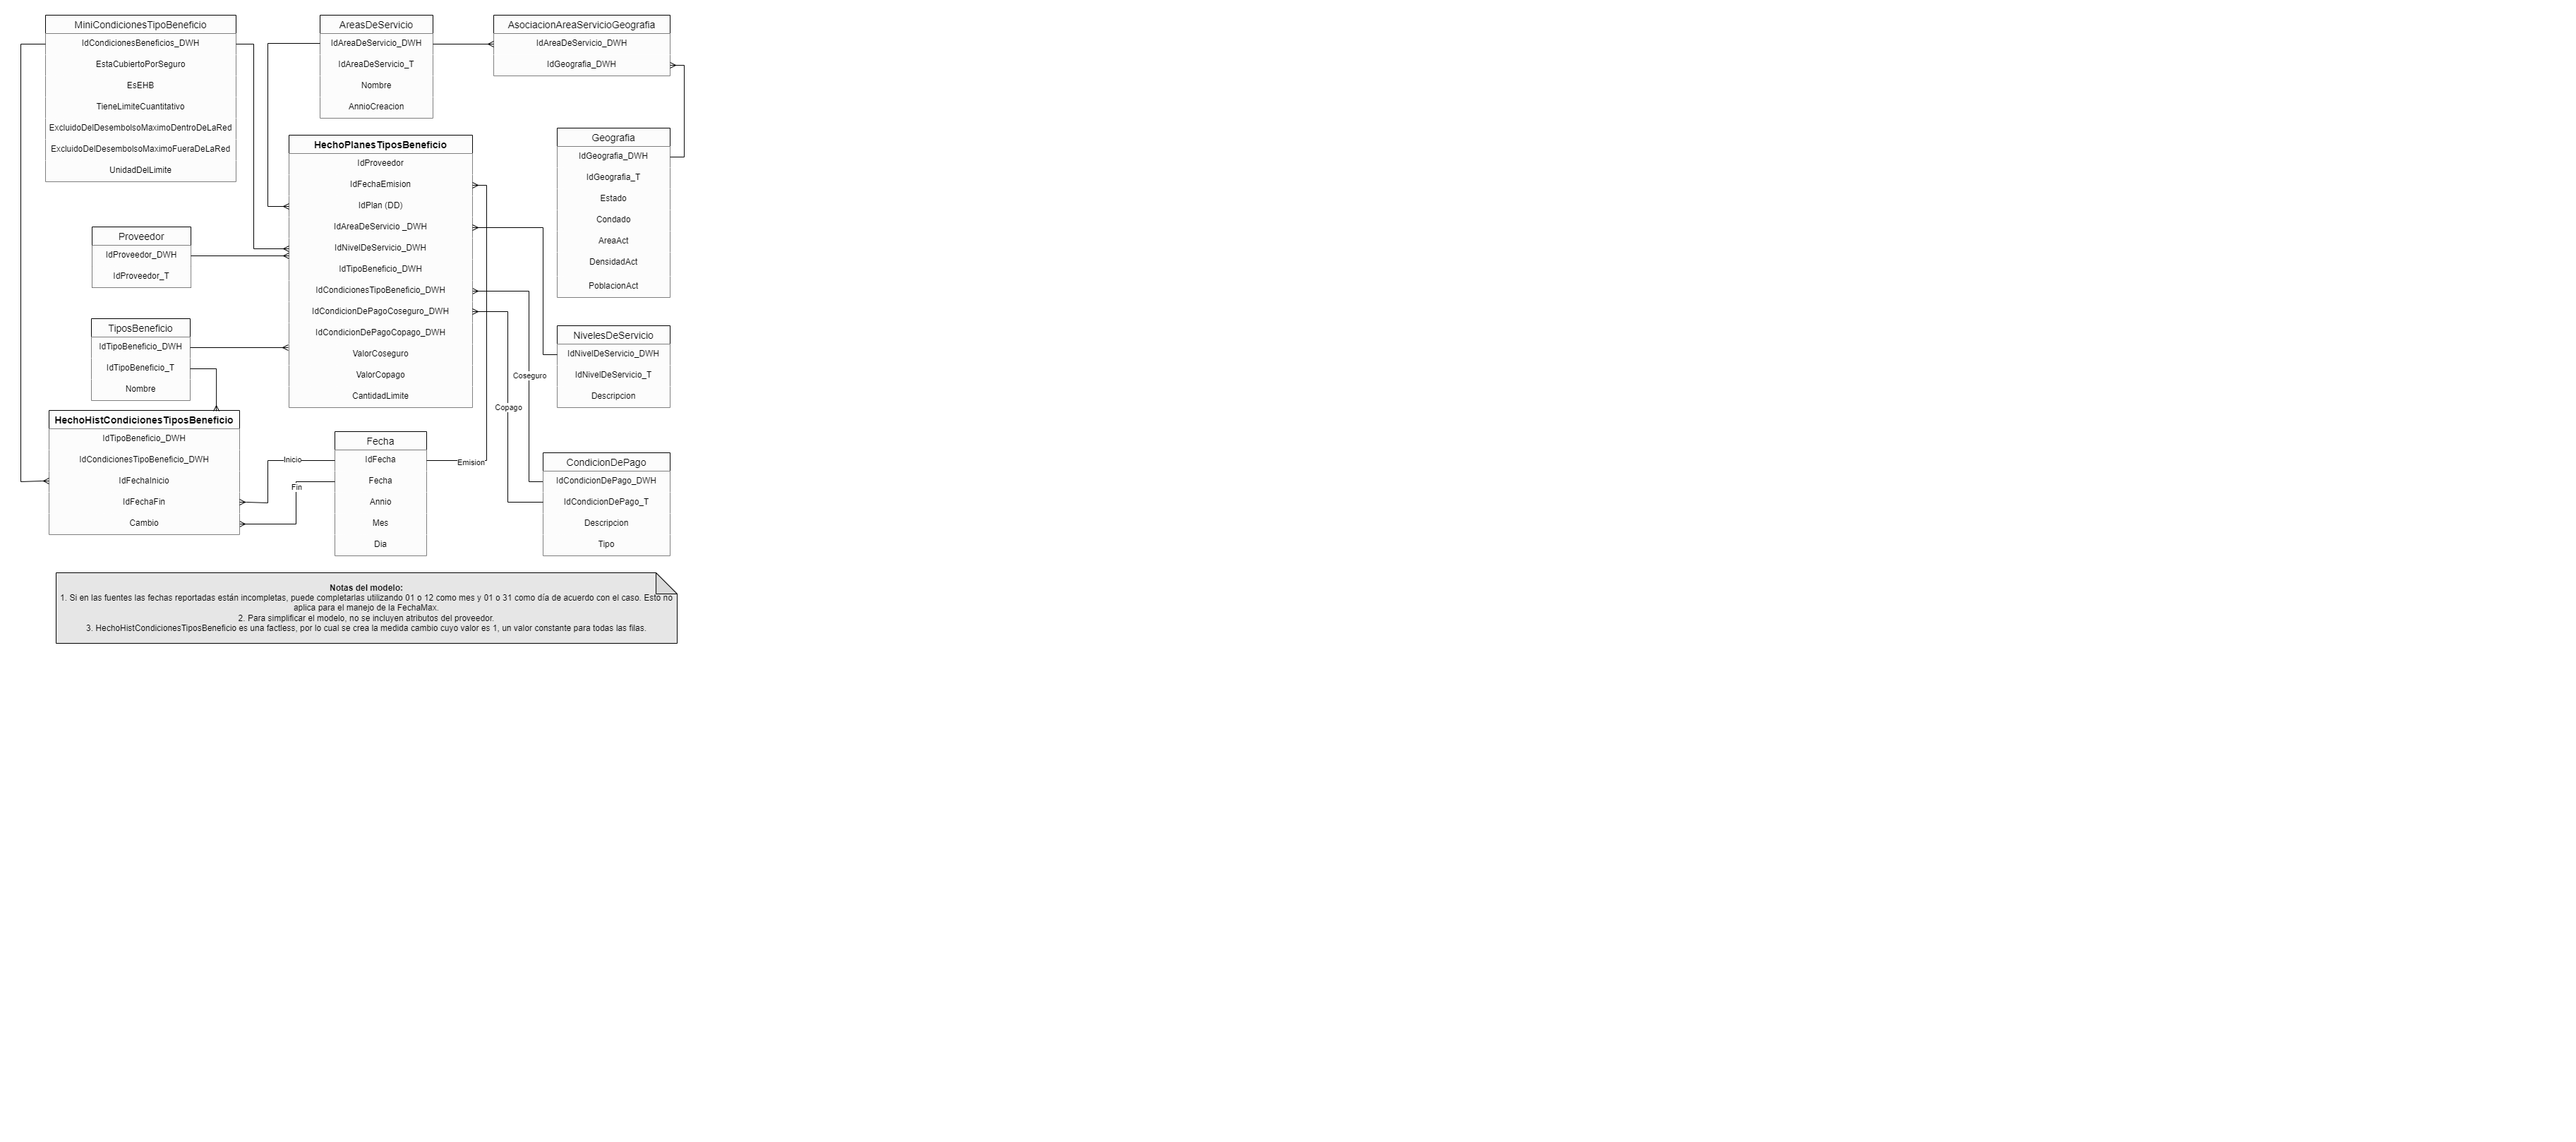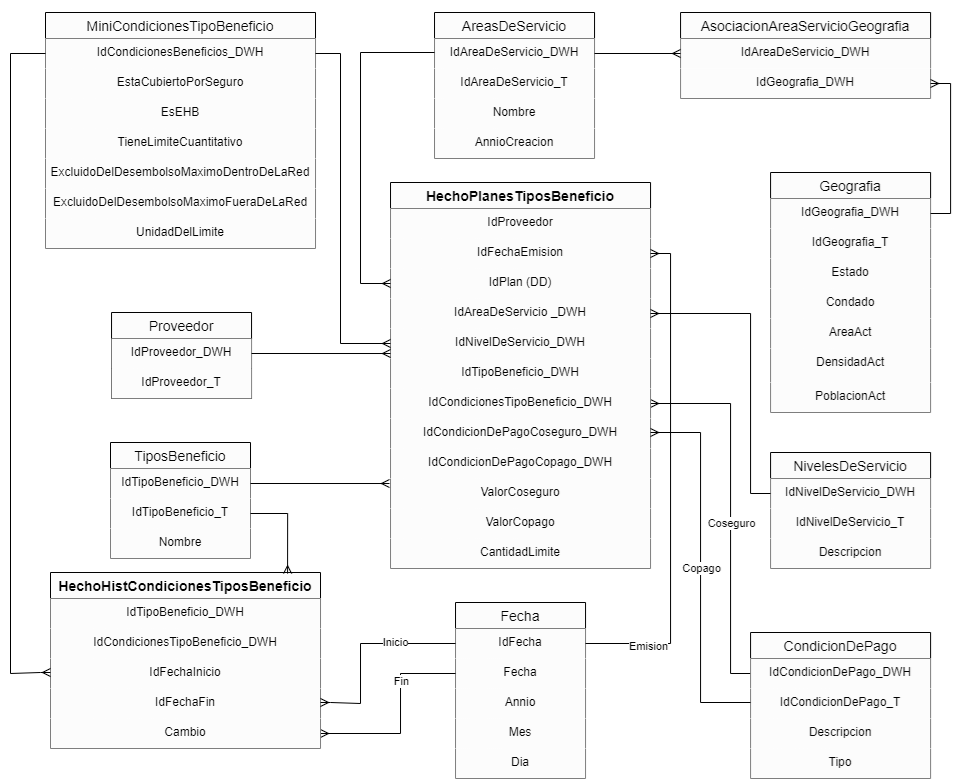)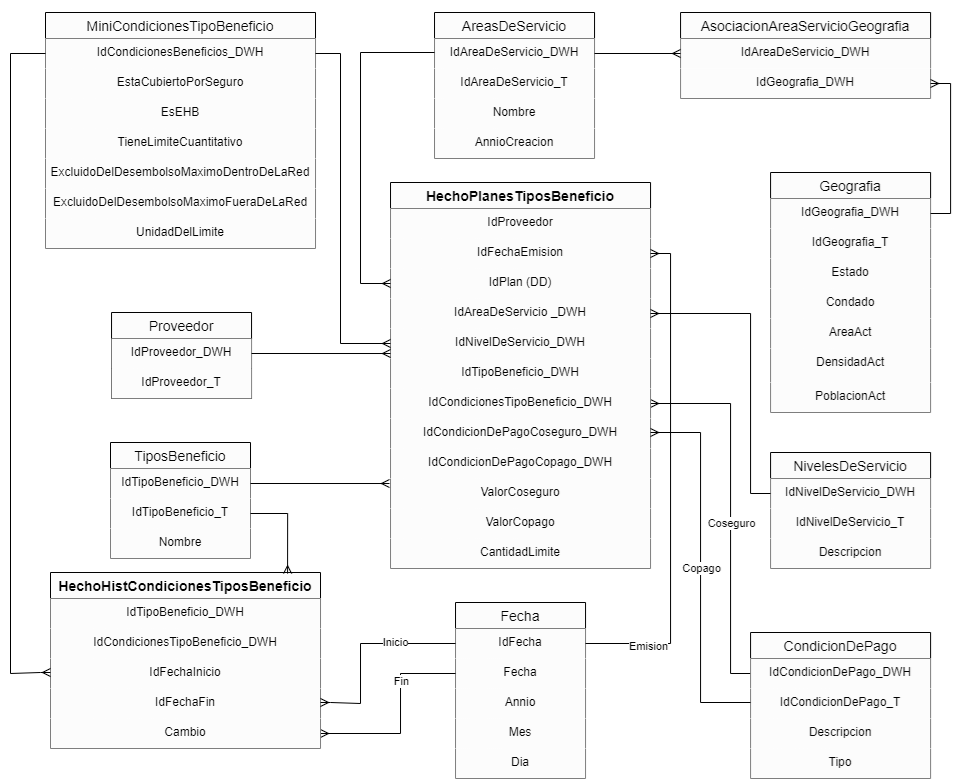

### Tabla AreaDeServicio:

**Extracción:**

In [9]:
# Sentencia SQL de extracción:
sql_areas_servicio = '''(SELECT IdAreaDeServicio_T, NombreAreaDeServicio, Fecha FROM FuenteAreasDeServicio_ETL) AS AreasDeServicio'''

# Extracción de datos con la función previamente definida:
t_areas_servicio = obtener_dataframe_de_bd(source_db_connection_string, sql_areas_servicio, db_user, db_psswd)

#Visualización de los datos extraidos:
t_areas_servicio_pd = t_areas_servicio.limit(5).toPandas()
display(HTML(t_areas_servicio_pd.to_html()))

,IdAreaDeServicio_T,NombreAreaDeServicio,Fecha
0,100622017,New Jersey - Medical91661NJ2340003-0520174859,2017
1,100722019,New Jersey - Medical91661NJ2340003-0520194597,2019
2,100922020,New Jersey - Medical91661NJ2340003-0520204858,2020
3,101012018,New Jersey - Medical91661NJ2340003-0520184611,2018
4,101062020,New Jersey - Medical91661NJ2340003-0520205037,2020


**Transformación:**

In [10]:
# Reorganizar y renombrar las columnas.
AreasDeServicio = t_areas_servicio.withColumn("IdAreaDeServicio_DWH", col("IdAreaDeServicio_T")) \
    .withColumnRenamed("Fecha", "AnnioCreacion") \
    .withColumnRenamed("NombreAreaDeServicio", "Nombre") \
    .select("IdAreaDeServicio_DWH", "IdAreaDeServicio_T", "Nombre", "AnnioCreacion")
AreasDeServicio.show()

# Eliminar los registros totalmente duplicados
AreasDeServicio = AreasDeServicio.dropDuplicates(['IdAreaDeServicio_T'])

# Verificar tipo de variable
AreasDeServicio_tipo=AreasDeServicio.dtypes
print(AreasDeServicio_tipo)

# Transformar variable a tipo de formato correspondiente
#AreasDeServicio = AreasDeServicio.withColumn('ID_Fecha', col('ID_Fecha').cast('Integer'))

+--------------------+------------------+--------------------+-------------+
|IdAreaDeServicio_DWH|IdAreaDeServicio_T|              Nombre|AnnioCreacion|
+--------------------+------------------+--------------------+-------------+
|           100622017|         100622017|New Jersey - Medi...|         2017|
|           100722019|         100722019|New Jersey  - Med...|         2019|
|           100922020|         100922020|New Jersey - Medi...|         2020|
|           101012018|         101012018|New Jersey - Medi...|         2018|
|           101062020|         101062020|New Jersey - Medi...|         2020|
|           101082018|         101082018|New Jersey - Medi...|         2018|
|           101152020|         101152020|New Jersey - Medi...|         2020|
|             1012019|           1012019|Dental11469KY0010...|         2019|
|           101242019|         101242019|New Jersey  - Med...|         2019|
|            10132017|          10132017|BlueOptions16842F...|         2017|

In [11]:
# Revisión datos vacíos.
print('Datos vacíos:')
print(contar_vacios(AreasDeServicio))
print()
# Revisión datos duplicados.
print('Filas y columnas de la tabla:', (AreasDeServicio.count(), len(AreasDeServicio.columns)))
print()
print('Índices únicos de la tabla:', AreasDeServicio.select('IdAreaDeServicio_DWH').distinct().count())
print()
print('Hay', AreasDeServicio.count() - AreasDeServicio.select('IdAreaDeServicio_DWH').distinct().count(), 'índices duplicados.')
print()
print('Summary:')
print(AreasDeServicio.summary().show())
print()

Datos vacíos:
[]

Filas y columnas de la tabla: (11620, 4)

Índices únicos de la tabla: 11620

Hay 0 índices duplicados.

Summary:
+-------+--------------------+-------------------+--------------------+------------------+
|summary|IdAreaDeServicio_DWH| IdAreaDeServicio_T|              Nombre|     AnnioCreacion|
+-------+--------------------+-------------------+--------------------+------------------+
|  count|               11620|              11620|               11620|             11620|
|   mean| 5.853717632745267E7|5.853717632745267E7|                NULL|2018.8403614457832|
| stddev| 3.395924254093369E7|3.395924254093369E7|                NULL|1.4419027149430639|
|    min|               12018|              12018|2021 Health Allia...|              2017|
|    25%|            29202018|           29202018|                NULL|              2018|
|    50%|            58302018|           58302018|                NULL|              2019|
|    75%|            87652021|           87652021|

**Carga:**

In [ ]:
guardar_db(dest_db_connection_string, AreasDeServicio, 'Estudiante_3_202413.AreasDeServicio', db_user, db_psswd)

### Tabla AsociacionAreaServicioGeografia:

**Extracción:**

In [13]:
# Sentencia SQL de extracción:
sql_AsociaciónAreaServicioGeografía = '''(SELECT IdAreaDeServicio_T, IdGeografia_T FROM FuenteAreasDeServicio_ETL) AS AsociaciónAreaServicioGeografía'''

# Extracción de datos con la función previamente definida:
t_AsociaciónAreaServicioGeografía = obtener_dataframe_de_bd(source_db_connection_string, sql_AsociaciónAreaServicioGeografía, db_user, db_psswd)

#Visualización de los datos extraidos:
t_AsociaciónAreaServicioGeografía_pd = t_AsociaciónAreaServicioGeografía.limit(5).toPandas()
display(HTML(t_AsociaciónAreaServicioGeografía_pd.to_html()))

,IdAreaDeServicio_T,IdGeografia_T
0,100622017,34005
1,100722019,34023
2,100922020,34019
3,101012018,34031
4,101062020,34031


**Transformación:**

In [14]:
# Reorganizar y renombrar las columnas.
AsociaciónAreaServicioGeografía = t_AsociaciónAreaServicioGeografía.withColumnRenamed("IdAreaDeServicio_T", "IdAreaDeServicio_DWH") \
    .withColumnRenamed("IdGeografia_T", "IdGeografia_DWH")
AsociaciónAreaServicioGeografía.show()

# Eliminar los registros totalmente duplicados
AsociaciónAreaServicioGeografía = AsociaciónAreaServicioGeografía.dropDuplicates(['IdAreaDeServicio_DWH'])

# Verificar tipo de variable
AsociaciónAreaServicioGeografía_tipo=AsociaciónAreaServicioGeografía.dtypes
print(AsociaciónAreaServicioGeografía_tipo)

# Transformar variable a tipo de formato correspondiente
#AsociaciónAreaServicioGeografía = AsociaciónAreaServicioGeografía.withColumn('ID_Fecha', col('ID_Fecha').cast('Integer'))

+--------------------+---------------+
|IdAreaDeServicio_DWH|IdGeografia_DWH|
+--------------------+---------------+
|           100622017|          34005|
|           100722019|          34023|
|           100922020|          34019|
|           101012018|          34031|
|           101062020|          34031|
|           101082018|          34037|
|           101152020|          34035|
|             1012019|          21041|
|           101242019|          34005|
|            10132017|          12031|
|           101332018|          34027|
|           101692019|          34035|
|           101712019|          34041|
|           101802019|          34025|
|           101852019|          34017|
|           101982018|          34003|
|             1022019|          21033|
|            10242017|          12107|
|           102442019|          34029|
|           102482020|          34021|
+--------------------+---------------+
only showing top 20 rows

[('IdAreaDeServicio_DWH', 'int'), ('Id

In [15]:
# Revisión datos vacíos.
print('Datos vacíos:')
print(contar_vacios(AsociaciónAreaServicioGeografía))
print()
# Revisión datos duplicados.
print('Filas y columnas de la tabla:', (AsociaciónAreaServicioGeografía.count(), len(AsociaciónAreaServicioGeografía.columns)))
print()
print('Índices únicos de la tabla:', AsociaciónAreaServicioGeografía.select('IdAreaDeServicio_DWH').distinct().count())
print()
print('Hay', AsociaciónAreaServicioGeografía.count() - AsociaciónAreaServicioGeografía.select('IdAreaDeServicio_DWH').distinct().count(), 'índices duplicados.')
print()
print('Summary:')
print(AsociaciónAreaServicioGeografía.summary().show())
print()

Datos vacíos:
[]

Filas y columnas de la tabla: (11620, 2)

Índices únicos de la tabla: 11620

Hay 0 índices duplicados.

Summary:
+-------+--------------------+------------------+
|summary|IdAreaDeServicio_DWH|   IdGeografia_DWH|
+-------+--------------------+------------------+
|  count|               11620|             11620|
|   mean| 5.853717632745267E7| 34220.08717728055|
| stddev|3.3959242540933706E7|14832.783826706469|
|    min|               12018|              1001|
|    25%|            29202018|             19019|
|    50%|            58302018|             35055|
|    75%|            87652021|             48141|
|    max|           117892019|             56045|
+-------+--------------------+------------------+

None



**Carga:**

In [ ]:
guardar_db(dest_db_connection_string, AsociaciónAreaServicioGeografía, 'Estudiante_3_202413.AsociaciónAreaServicioGeografía', db_user, db_psswd)

### Tabla Geografia:

**Extracción:**

In [16]:
# Sentencia SQL de extracción:
sql_Geografía = '''(SELECT IdGeografia_T, Condado, Estado, PoblacionAct, Area, Densidad FROM FuenteAreasDeServicio_ETL) AS Geografía'''

# Extracción de datos con la función previamente definida:
t_Geografía = obtener_dataframe_de_bd(source_db_connection_string, sql_Geografía, db_user, db_psswd)

#Visualización de los datos extraidos:
t_Geografía_pd = t_Geografía.limit(5).toPandas()
display(HTML(t_Geografía_pd.to_html()))

,IdGeografia_T,Condado,Estado,PoblacionAct,Area,Densidad
0,34005,Burlington County,New Jersey,464269,805.0,577.0
1,34023,Middlesex County,New Jersey,860807,311.0,2768.0
2,34019,Hunterdon County,New Jersey,129924,430.0,302.0
3,34031,Passaic County,New Jersey,518117,185.0,2801.0
4,34031,Passaic County,New Jersey,518117,185.0,2801.0


**Transformación:**

In [17]:
# Reorganizar y renombrar las columnas.
Geografía = t_Geografía.withColumn("IdGeografia_DWH", col("IdGeografia_T")) \
    .withColumnRenamed("Area", "AreaAct") \
    .withColumnRenamed("Densidad", "DensidadAct") \
    .select("IdGeografia_DWH", "IdGeografia_T", "Estado", "Condado", "AreaAct", "DensidadAct", "PoblacionAct")

#Corregir registros con áreas negativas
Geografía = Geografía.withColumn('AreaAct', f.abs(f.col('AreaAct')))

# Eliminar registros con DensidadAct igual a 0
Geografía = Geografía.filter(col("DensidadAct") != 0)

# Eliminar los últimos 4 digitos de la variable PoblacionAct
def corregir_poblacion_act(poblacion):
    poblacion_str = str(poblacion)
    if poblacion_str.endswith("0001"):
        return int(poblacion_str[:-4])
    return poblacion

corregir_poblacion_act_udf = f.udf(corregir_poblacion_act)

# Aplicar la corrección a la columna PoblacionAct
Geografía = Geografía.withColumn("PoblacionAct", corregir_poblacion_act_udf(Geografía["PoblacionAct"]))

# Eliminar los registros totalmente duplicados
Geografía = Geografía.dropDuplicates(['IdGeografia_DWH'])

# Verificar tipo de variable
Geografía_tipo=Geografía.dtypes
print(Geografía_tipo)

# Transformar variable a tipo de formato correspondiente
#Geografía = Geografía.withColumn('ID_Fecha', col('ID_Fecha').cast('Integer'))


Geografía.show()

[('IdGeografia_DWH', 'int'), ('IdGeografia_T', 'int'), ('Estado', 'string'), ('Condado', 'string'), ('AreaAct', 'double'), ('DensidadAct', 'double'), ('PoblacionAct', 'string')]
+---------------+-------------+-------+----------------+-------+-----------+------------+
|IdGeografia_DWH|IdGeografia_T| Estado|         Condado|AreaAct|DensidadAct|PoblacionAct|
+---------------+-------------+-------+----------------+-------+-----------+------------+
|           1001|         1001|Alabama|  Autauga County|  594.0|       99.0|       59095|
|           1003|         1003|Alabama|  Baldwin County| 1589.0|      151.0|      239294|
|           1005|         1005|Alabama|  Barbour County|  884.0|       28.0|       24964|
|           1007|         1007|Alabama|     Bibb County|  622.0|       36.0|       22477|
|           1009|         1009|Alabama|   Blount County|  644.0|       92.0|       59041|
|           1011|         1011|Alabama|  Bullock County|  622.0|       17.0|       10320|
|           

In [18]:
# Revisión datos vacíos.
print('Datos vacíos:')
print(contar_vacios(Geografía))
print()
# Revisión datos duplicados.
print('Filas y columnas de la tabla:', (Geografía.count(), len(Geografía.columns)))
print()
print('Índices únicos de la tabla:', Geografía.select('IdGeografia_DWH').distinct().count())
print()
print('Hay', Geografía.count() - Geografía.select('IdGeografia_DWH').distinct().count(), 'índices duplicados.')
print()
print('Summary:')
print(Geografía.summary().show())
print()

Datos vacíos:
[]

Filas y columnas de la tabla: (2598, 7)

Índices únicos de la tabla: 2598

Hay 0 índices duplicados.

Summary:
+-------+------------------+------------------+-------+----------------+------------------+-----------------+------------------+
|summary|   IdGeografia_DWH|     IdGeografia_T| Estado|         Condado|           AreaAct|      DensidadAct|      PoblacionAct|
+-------+------------------+------------------+-------+----------------+------------------+-----------------+------------------+
|  count|              2598|              2598|   2598|            2598|              2598|             2598|              2598|
|   mean|30939.411085450345|30939.411085450345|   NULL|            NULL| 868.3487297921478|162.2621247113164| 85848.67667436489|
| stddev|14791.809548870548|14791.809548870548|   NULL|            NULL|1173.0550949120811|564.4671940227059|247727.90275949385|
|    min|              1001|              1001|Alabama|Abbeville County|               5.0|      

**Carga:**

In [ ]:
guardar_db(dest_db_connection_string, Geografía, 'Estudiante_3_202413.Geografía', db_user, db_psswd)

### Tabla NivelesDeServicio:

**Extracción:**

In [19]:
# Sentencia SQL de extracción:
sql_NivelesDeServicio = '''(SELECT IdNivelDeServicio_DWH, IdNivelDeServicio_T,Descripcion FROM NivelesDeServicio) AS NivelesDeServicio'''

# Extracción de datos con la función previamente definida:
t_NivelesDeServicio = obtener_dataframe_de_bd(source_db_connection_string, sql_NivelesDeServicio, db_user, db_psswd)

#Visualización de los datos extraidos:
t_NivelesDeServicio_pd = t_NivelesDeServicio.limit(5).toPandas()
display(HTML(t_NivelesDeServicio_pd.to_html()))

,IdNivelDeServicio_DWH,IdNivelDeServicio_T,Descripcion
0,1,1,Nivel 1
1,2,2,Nivel 2
2,3,3,Fuera de la red


**Transformación:**

In [20]:
# Eliminar los registros totalmente duplicados
NivelesDeServicio = t_NivelesDeServicio.dropDuplicates(['IdNivelDeServicio_DWH'])

# Verificar tipo de variable
NivelesDeServicio_tipo=NivelesDeServicio.dtypes
print(NivelesDeServicio_tipo)

# Transformar variable a tipo de formato correspondiente
#NivelesDeServicio = NivelesDeServicio.withColumn('ID_Fecha', col('ID_Fecha').cast('Integer'))

[('IdNivelDeServicio_DWH', 'int'), ('IdNivelDeServicio_T', 'int'), ('Descripcion', 'string')]


In [21]:
# Revisión datos vacíos.
print('Datos vacíos:')
print(contar_vacios(NivelesDeServicio))
print()
# Revisión datos duplicados.
print('Filas y columnas de la tabla:', (NivelesDeServicio.count(), len(NivelesDeServicio.columns)))
print()
print('Índices únicos de la tabla:', NivelesDeServicio.select('IdNivelDeServicio_DWH').distinct().count())
print()
print('Hay', NivelesDeServicio.count() - NivelesDeServicio.select('IdNivelDeServicio_DWH').distinct().count(), 'índices duplicados.')
print()
print('Summary:')
print(NivelesDeServicio.summary().show())
print()

Datos vacíos:
[]

Filas y columnas de la tabla: (3, 3)

Índices únicos de la tabla: 3

Hay 0 índices duplicados.

Summary:
+-------+---------------------+-------------------+---------------+
|summary|IdNivelDeServicio_DWH|IdNivelDeServicio_T|    Descripcion|
+-------+---------------------+-------------------+---------------+
|  count|                    3|                  3|              3|
|   mean|                  2.0|                2.0|           NULL|
| stddev|                  1.0|                1.0|           NULL|
|    min|                    1|                  1|Fuera de la red|
|    25%|                    1|                  1|           NULL|
|    50%|                    2|                  2|           NULL|
|    75%|                    3|                  3|           NULL|
|    max|                    3|                  3|        Nivel 2|
+-------+---------------------+-------------------+---------------+

None



**Carga:**

In [ ]:
guardar_db(dest_db_connection_string, NivelesDeServicio, 'Estudiante_3_202413.NivelesDeServicio', db_user, db_psswd)

### Tabla HechoPlanesTipoBeneficio

**Extracción:**

Verificación de campos en fuentes de datos

In [9]:
# Listar columnas de la tabla FuentePlanesBeneficio_ETL
planes_beneficio_columns = spark.read.format('jdbc') \
    .option('url', source_db_connection_string) \
    .option('dbtable', 'FuentePlanesBeneficio_ETL') \
    .option('user', db_user) \
    .option('password', db_psswd) \
    .option('driver', 'com.mysql.cj.jdbc.Driver') \
    .load()

# Mostrar las columnas
planes_beneficio_columns.printSchema()


root
 |-- IdTipoBeneficio_T: integer (nullable = true)
 |-- IdAreaDeServicio_T: integer (nullable = true)
 |-- IdCondicionDePagoCopago_T: integer (nullable = true)
 |-- IdCondicionDePagoCoseguro_T: integer (nullable = true)
 |-- IdNivelServicio_T: integer (nullable = true)
 |-- IdPlan_T: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- IdProveedor_T: integer (nullable = true)
 |-- valorCopago: integer (nullable = true)
 |-- valorCoseguro: string (nullable = true)
 |-- cantidadLimite: double (nullable = true)



In [10]:
# Listar columnas de la tabla FuenteTiposBeneficio_ETL
planes_beneficio_columns = spark.read.format('jdbc') \
    .option('url', source_db_connection_string) \
    .option('dbtable', 'FuenteTiposBeneficio_ETL') \
    .option('user', db_user) \
    .option('password', db_psswd) \
    .option('driver', 'com.mysql.cj.jdbc.Driver') \
    .load()

# Mostrar las columnas
planes_beneficio_columns.printSchema()

root
 |-- IdTipoBeneficio_T: integer (nullable = true)
 |-- Nombre: string (nullable = true)
 |-- UnidadDelLimite: string (nullable = true)
 |-- EsEHB: string (nullable = true)
 |-- EstaCubiertaPorSeguro: string (nullable = true)
 |-- TieneLimiteCuantitativo: string (nullable = true)
 |-- ExcluidoDelDesembolsoMaximoDentroDeLaRed: string (nullable = true)
 |-- ExcluidoDelDesembolsoMaximoFueraDeLaRed: string (nullable = true)
 |-- Fecha: integer (nullable = true)



In [11]:
# Listar columnas de la tabla FuenteAreasDeServicio_ETL
planes_beneficio_columns = spark.read.format('jdbc') \
    .option('url', source_db_connection_string) \
    .option('dbtable', 'FuenteAreasDeServicio_ETL') \
    .option('user', db_user) \
    .option('password', db_psswd) \
    .option('driver', 'com.mysql.cj.jdbc.Driver') \
    .load()

# Mostrar las columnas
planes_beneficio_columns.printSchema()

root
 |-- IdAreaDeServicio_T: integer (nullable = true)
 |-- NombreAreaDeServicio: string (nullable = true)
 |-- IdGeografia_T: integer (nullable = true)
 |-- Condado: string (nullable = true)
 |-- Estado: string (nullable = true)
 |-- PoblacionAct: string (nullable = true)
 |-- Area: double (nullable = true)
 |-- Densidad: double (nullable = true)
 |-- Fecha: integer (nullable = true)



In [12]:
# Listar columnas de la tabla FuenteCondicionesDePago_ETL
planes_beneficio_columns = spark.read.format('jdbc') \
    .option('url', source_db_connection_string) \
    .option('dbtable', 'FuenteCondicionesDePago_ETL') \
    .option('user', db_user) \
    .option('password', db_psswd) \
    .option('driver', 'com.mysql.cj.jdbc.Driver') \
    .load()

# Mostrar las columnas
planes_beneficio_columns.printSchema()

root
 |-- IdCondicionesDePago_T: integer (nullable = true)
 |-- Descripcion: string (nullable = true)
 |-- Tipo: string (nullable = true)



In [13]:
# Extracción de datos de FuentePlanesBeneficio_ETL
sql_planes_beneficio = '''(SELECT IdTipoBeneficio_T, IdAreaDeServicio_T, IdCondicionDePagoCopago_T, IdCondicionDePagoCoseguro_T, IdNivelServicio_T, IdPlan_T, Fecha as FechaPlanes, IdProveedor_T, valorCopago, valorCoseguro, cantidadLimite FROM FuentePlanesBeneficio_ETL) AS PlanesBeneficio'''
planes_beneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_planes_beneficio, db_user, db_psswd)

# Extracción de datos de FuenteTiposBeneficio_ETL
sql_tipos_beneficio = '''(SELECT IdTipoBeneficio_T, Nombre as NombreTipoBeneficio, UnidadDelLimite, EsEHB, EstaCubiertaPorSeguro, TieneLimiteCuantitativo, ExcluidoDelDesembolsoMaximoDentroDeLaRed, ExcluidoDelDesembolsoMaximoFueraDeLaRed, Fecha as FechaTiposBeneficio FROM FuenteTiposBeneficio_ETL) AS TiposBeneficio'''
tipos_beneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_tipos_beneficio, db_user, db_psswd)

# Extracción de datos de FuenteAreasDeServicio_ETL
sql_areas_servicio = '''(SELECT IdAreaDeServicio_T, NombreAreaDeServicio, IdGeografia_T, Condado, Estado, PoblacionAct, Area, Densidad, Fecha as FechaAreasServicio FROM FuenteAreasDeServicio_ETL) AS AreasDeServicio'''
areas_servicio = obtener_dataframe_de_bd(source_db_connection_string, sql_areas_servicio, db_user, db_psswd)

# Extracción de datos de FuenteCondicionesDePago_ETL
sql_condiciones_pago = '''(SELECT IdCondicionesDePago_T, Descripcion, Tipo FROM FuenteCondicionesDePago_ETL) AS CondicionesDePago'''
condiciones_pago = obtener_dataframe_de_bd(source_db_connection_string, sql_condiciones_pago, db_user, db_psswd)

**Transformación:**

In [14]:
# Realizar las uniones necesarias
hechos_planes_tipo_beneficio = planes_beneficio \
    .join(tipos_beneficio, on="IdTipoBeneficio_T", how="left") \
    .join(areas_servicio, on="IdAreaDeServicio_T", how="left") \
    .join(condiciones_pago.alias("copago"), planes_beneficio.IdCondicionDePagoCopago_T == col("copago.IdCondicionesDePago_T"), how="left") \
    .join(condiciones_pago.alias("coseguro"), planes_beneficio.IdCondicionDePagoCoseguro_T == col("coseguro.IdCondicionesDePago_T"), how="left")


In [18]:
# Realizar las renombraciones necesarias para HechosPlanesTiposBeneficio
hechos_planes_tipo_beneficio = hechos_planes_tipo_beneficio \
    .withColumnRenamed("IdProveedor_T", "IdProveedor") \
    .withColumnRenamed("IdPlan_T", "IdPlan(DD)") \
    .withColumnRenamed("IdAreaDeServicio_T", "IdAreaDeServicio_DWH") \
    .withColumnRenamed("IdNivelServicio_T", "IdNivelServicio_DWH") \
    .withColumnRenamed("IdTipoBeneficio_T", "IdTipoBeneficio_DWH") \
    .withColumnRenamed("IdCondicionDePagoCoseguro_T", "IdCondicionDePagoCoseguro_DWH") \
    .withColumnRenamed("IdCondicionDePagoCopago_T", "IdCondicionDePagoCopago_DWH") \
    .withColumnRenamed("valorCoseguro", "ValorCoseguro") \
    .withColumnRenamed("valorCopago", "ValorCopago") \
    .withColumnRenamed("cantidadLimite", "CantidadLimite")

# Convertir la columna FechaEmision al formato de fecha
hechos_planes_tipo_beneficio = hechos_planes_tipo_beneficio \
    .withColumn("FechaEmision", to_date(concat_ws("-", col("FechaTiposBeneficio"), lit("12"), lit("31")), "yyyy-MM-dd"))

# Seleccionar las columnas finales
hechos_planes_tipo_beneficio = hechos_planes_tipo_beneficio \
    .select("IdProveedor", "FechaEmision", "IdPlan(DD)", "IdAreaDeServicio_DWH", "IdNivelServicio_DWH", "IdTipoBeneficio_DWH", "IdCondicionDePagoCoseguro_DWH", "IdCondicionDePagoCopago_DWH", "ValorCoseguro", "ValorCopago", "CantidadLimite")

# Mostrar la estructura del DataFrame final
hechos_planes_tipo_beneficio.printSchema()
hechos_planes_tipo_beneficio.show(5)

root
 |-- IdProveedor: integer (nullable = true)
 |-- FechaEmision: date (nullable = true)
 |-- IdPlan(DD): string (nullable = true)
 |-- IdAreaDeServicio_DWH: integer (nullable = true)
 |-- IdNivelServicio_DWH: integer (nullable = true)
 |-- IdTipoBeneficio_DWH: integer (nullable = true)
 |-- IdCondicionDePagoCoseguro_DWH: integer (nullable = true)
 |-- IdCondicionDePagoCopago_DWH: integer (nullable = true)
 |-- ValorCoseguro: string (nullable = true)
 |-- ValorCopago: integer (nullable = true)
 |-- CantidadLimite: double (nullable = true)

+-----------+------------+-----------------+--------------------+-------------------+-------------------+-----------------------------+---------------------------+-------------+-----------+--------------+
|IdProveedor|FechaEmision|       IdPlan(DD)|IdAreaDeServicio_DWH|IdNivelServicio_DWH|IdTipoBeneficio_DWH|IdCondicionDePagoCoseguro_DWH|IdCondicionDePagoCopago_DWH|ValorCoseguro|ValorCopago|CantidadLimite|
+-----------+------------+----------------

In [20]:
# Verificación de datos vacíos
print('Datos vacíos:')
print(contar_vacios(hechos_planes_tipo_beneficio))

# Verificación de datos duplicados
print('Filas y columnas de la tabla:', (hechos_planes_tipo_beneficio.count(), len(hechos_planes_tipo_beneficio.columns)))
print('Índices únicos de la tabla:', hechos_planes_tipo_beneficio.select('IdProveedor').distinct().count())
print('Hay', hechos_planes_tipo_beneficio.count() - hechos_planes_tipo_beneficio.select('IdProveedor').distinct().count(), 'índices duplicados.')

# Summary
print(hechos_planes_tipo_beneficio.summary().show())

Datos vacíos:
Número de vacíos para columna CantidadLimite: 8096322
[('CantidadLimite', 8096322)]
Filas y columnas de la tabla: (10510881, 11)
Índices únicos de la tabla: 171
Hay 10510710 índices duplicados.
+-------+------------------+-----------------+--------------------+-------------------+-------------------+-----------------------------+---------------------------+------------------+------------------+------------------+
|summary|       IdProveedor|       IdPlan(DD)|IdAreaDeServicio_DWH|IdNivelServicio_DWH|IdTipoBeneficio_DWH|IdCondicionDePagoCoseguro_DWH|IdCondicionDePagoCopago_DWH|     ValorCoseguro|       ValorCopago|    CantidadLimite|
+-------+------------------+-----------------+--------------------+-------------------+-------------------+-----------------------------+---------------------------+------------------+------------------+------------------+
|  count|          10510881|         10510881|            10510881|           10510881|           10510881|                

**Carga:**

In [ ]:
# Guardar los datos transformados en la tabla HechoPlanesTipoBeneficio
guardar_db(dest_db_connection_string, hechos_planes_tipo_beneficio, 'Estudiante_3_202413.HechoPlanesTipoBeneficio', db_user, db_psswd)

### Tabla TiposBeneficio

**Extracción:**

In [32]:
# Sentencia SQL de extracción:
sql_tipo_beneficio = '''(SELECT IdTipoBeneficio_T, Nombre FROM FuenteTiposBeneficio_ETL) AS FuenteTiposBeneficio'''

# Extracción de datos con la función previamente definida:
t_tipo_beneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_tipo_beneficio, db_user, db_psswd)

#Visualización de los datos extraidos:
t_tipo_beneficio_pd = t_tipo_beneficio.limit(5).toPandas()
display(HTML(t_tipo_beneficio_pd.to_html()))

,IdTipoBeneficio_T,Nombre
0,5,Abortion For Which Public Funding Is Prohibited
1,5,Abortion For Which Public Funding Is Prohibited
2,10,Accidental Dental
3,10,Accidental Dental
4,20,Adult Frames And Lenses


**Transformación:**

In [33]:
# Reorganizar y renombrar las columnas.
TipoBeneficio = t_tipo_beneficio.withColumn("IdTipoBeneficio_DWH", col("IdTipoBeneficio_T")) \
        .select("IdTipoBeneficio_DWH", "IdTipoBeneficio_T", "Nombre")

# Eliminar los registros totalmente duplicados
TipoBeneficio = TipoBeneficio.dropDuplicates(['IdTipoBeneficio_T'])

# Verificación de datos vacíos
print('Datos vacíos:')
print(contar_vacios(TipoBeneficio))

# Verificar tipo de variable
TipoBeneficio_tipo=TipoBeneficio.dtypes
print(TipoBeneficio_tipo)

TipoBeneficio.show()

Datos vacíos:
[]
[('IdTipoBeneficio_DWH', 'int'), ('IdTipoBeneficio_T', 'int'), ('Nombre', 'string')]
+-------------------+-----------------+--------------------+
|IdTipoBeneficio_DWH|IdTipoBeneficio_T|              Nombre|
+-------------------+-----------------+--------------------+
|                  5|                5|Abortion For Whic...|
|                 10|               10|   Accidental Dental|
|                 15|               15|         Acupuncture|
|                 20|               20|Adult Frames And ...|
|                 25|               25|  Allergy Injections|
|                 30|               30|     Allergy Testing|
|                 35|               35|Amino Acid-based ...|
|                 40|               40|          Anesthesia|
|                 45|               45|Anesthesia Servic...|
|                 50|               50|Applied Behavior ...|
|                 55|               55|Attention Deficit...|
|                 60|               60|Autis

**Carga:**

In [ ]:
guardar_db(dest_db_connection_string, TipoBeneficio,'Estudiante_3_202413.TipoBeneficio', db_user, db_psswd)

### Tabla Fecha

**Extraccion:**

In [35]:
# Sentencia SQL de extracción:
sql_fecha = '''(SELECT Fecha FROM FuenteTiposBeneficio_ETL) AS FuenteTiposBeneficio'''

# Extracción de datos con la función previamente definida:
t_fecha = obtener_dataframe_de_bd(source_db_connection_string, sql_fecha, db_user, db_psswd)

#Visualización de los datos extraidos:
t_fecha_pd = t_fecha.limit(5).toPandas()
display(HTML(t_fecha_pd.to_html()))

,Fecha
0,2017
1,2020
2,2017
3,2019
4,2019


**Transfromacion:**


In [36]:
# Eliminar los registros totalmente duplicados
Fecha = t_fecha.dropDuplicates(['Fecha'])

# Verificación de datos vacíos
print('Datos vacíos:')
print(contar_vacios(Fecha))

# Reorganizar, renombrar y crear las columnas.
Fecha = Fecha.withColumn("Annio", col("Fecha")) \
        .withColumn("Mes", lit("12")) \
        .withColumn("Dia", lit("31")) \
        .withColumn("Fecha", to_date(concat_ws("-", col("Annio"), col("Mes"), col("Dia")), "yyyy-MM-dd")) \
        .withColumn("IdFecha", concat(col("Annio"), lpad(col("mes"), 2, "0"), lpad(col("dia"), 2, "0"))) \
        .select("IdFecha", "Fecha", "Annio", "Mes", "Dia")


# Verificar tipo de variable
Fecha_tipo=Fecha.dtypes
print(Fecha_tipo)

Fecha.show()

Datos vacíos:
[]
[('IdFecha', 'string'), ('Fecha', 'date'), ('Annio', 'int'), ('Mes', 'string'), ('Dia', 'string')]
+--------+----------+-----+---+---+
| IdFecha|     Fecha|Annio|Mes|Dia|
+--------+----------+-----+---+---+
|20181231|2018-12-31| 2018| 12| 31|
|20191231|2019-12-31| 2019| 12| 31|
|20201231|2020-12-31| 2020| 12| 31|
|20171231|2017-12-31| 2017| 12| 31|
|20211231|2021-12-31| 2021| 12| 31|
+--------+----------+-----+---+---+



**Cargue:**

In [ ]:
guardar_db(dest_db_connection_string, Fecha,'Estudiante_3_202413.Fecha', db_user, db_psswd)

### Tabla MiniCondicionesTipoBeneficio

**Extración:**

Verificación columnas en fuente de datos

In [37]:
# Listar columnas de la tabla FuentePlanesBeneficio_ETL
planes_beneficio_columns = spark.read.format('jdbc') \
    .option('url', source_db_connection_string) \
    .option('dbtable', 'FuentePlanesBeneficio_ETL') \
    .option('user', db_user) \
    .option('password', db_psswd) \
    .option('driver', 'com.mysql.cj.jdbc.Driver') \
    .load()

# Mostrar las columnas
planes_beneficio_columns.printSchema()


root
 |-- IdTipoBeneficio_T: integer (nullable = true)
 |-- IdAreaDeServicio_T: integer (nullable = true)
 |-- IdCondicionDePagoCopago_T: integer (nullable = true)
 |-- IdCondicionDePagoCoseguro_T: integer (nullable = true)
 |-- IdNivelServicio_T: integer (nullable = true)
 |-- IdPlan_T: string (nullable = true)
 |-- Fecha: string (nullable = true)
 |-- IdProveedor_T: integer (nullable = true)
 |-- valorCopago: integer (nullable = true)
 |-- valorCoseguro: string (nullable = true)
 |-- cantidadLimite: double (nullable = true)



In [38]:
# Extracción de datos desde FuenteTiposBeneficio_ETL
sql_tipos_beneficio = '''(SELECT IdTipoBeneficio_T, Nombre, UnidadDelLimite, EsEHB, EstaCubiertaPorSeguro, TieneLimiteCuantitativo, ExcluidoDelDesembolsoMaximoDentroDeLaRed, ExcluidoDelDesembolsoMaximoFueraDeLaRed, Fecha FROM FuenteTiposBeneficio_ETL) AS TiposBeneficio'''

tipos_beneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_tipos_beneficio, db_user, db_psswd)

# Extracción de datos desde FuentePlanesBeneficio_ETL
sql_planes_beneficio = '''(SELECT IdTipoBeneficio_T, IdAreaDeServicio_T, IdCondicionDePagoCopago_T, IdCondicionDePagoCoseguro_T, IdNivelServicio_T, IdPlan_T, Fecha, IdProveedor_T, valorCopago, valorCoseguro, cantidadLimite FROM FuentePlanesBeneficio_ETL) AS PlanesBeneficio'''

planes_beneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_planes_beneficio, db_user, db_psswd)

Se exploran los datos que van a ser transformados a boolean con el formato "Yes" y "No"

In [39]:
tipos_beneficio.groupBy("EstaCubiertaPorSeguro").count().show()
tipos_beneficio.groupBy("EsEHB").count().show()
tipos_beneficio.groupBy("TieneLimiteCuantitativo").count().show()
tipos_beneficio.groupBy("ExcluidoDelDesembolsoMaximoDentroDeLaRed").count().show()
tipos_beneficio.groupBy("ExcluidoDelDesembolsoMaximoFueraDeLaRed").count().show()
tipos_beneficio.groupBy("UnidadDelLimite").count().show()

+---------------------+-----+
|EstaCubiertaPorSeguro|count|
+---------------------+-----+
|                False|    2|
|                   No|   39|
|                  Yes|  408|
+---------------------+-----+

+-----+-----+
|EsEHB|count|
+-----+-----+
|   No|  293|
|  Yes|  134|
| True|   22|
+-----+-----+

+-----------------------+-----+
|TieneLimiteCuantitativo|count|
+-----------------------+-----+
|                     No|  273|
|                    Yes|  163|
|                     Si|   13|
+-----------------------+-----+

+----------------------------------------+-----+
|ExcluidoDelDesembolsoMaximoDentroDeLaRed|count|
+----------------------------------------+-----+
|                                      No|  424|
|                                     Yes|   25|
+----------------------------------------+-----+

+---------------------------------------+-----+
|ExcluidoDelDesembolsoMaximoFueraDeLaRed|count|
+---------------------------------------+-----+
|                         

**Transformación:**

In [40]:
# Extracción de datos desde FuenteTiposBeneficio_ETL
sql_tipos_beneficio = '''(SELECT IdTipoBeneficio_T, Nombre, UnidadDelLimite, EsEHB, EstaCubiertaPorSeguro, TieneLimiteCuantitativo, ExcluidoDelDesembolsoMaximoDentroDeLaRed, ExcluidoDelDesembolsoMaximoFueraDeLaRed, Fecha FROM FuenteTiposBeneficio_ETL) AS TiposBeneficio'''

tipos_beneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_tipos_beneficio, db_user, db_psswd)

# Extracción de datos desde FuentePlanesBeneficio_ETL
sql_planes_beneficio = '''(SELECT IdTipoBeneficio_T, IdAreaDeServicio_T, IdCondicionDePagoCopago_T, IdCondicionDePagoCoseguro_T, IdNivelServicio_T, IdPlan_T, Fecha, IdProveedor_T, valorCopago, valorCoseguro, cantidadLimite FROM FuentePlanesBeneficio_ETL) AS PlanesBeneficio'''

planes_beneficio = obtener_dataframe_de_bd(source_db_connection_string, sql_planes_beneficio, db_user, db_psswd)

# Realizar la unión de tablas
planes_beneficio_unido = planes_beneficio.join(tipos_beneficio, on="IdTipoBeneficio_T", how="left")

# Generar idCondicionesBeneficios_DWH y crear las columnas necesarias
MiniCondicionesTipoBeneficio = planes_beneficio_unido.withColumn("idCondicionesBeneficios_DWH", expr("uuid()")) \
    .withColumn("EstaCubiertoPorSeguro", when(col("EstaCubiertaPorSeguro").isin("Y", "True", "Yes"), "Yes").otherwise("No")) \
    .withColumn("EsEHB", when(col("EsEHB") == "True", "Yes").otherwise(col("EsEHB"))) \
    .withColumn("TieneLimiteCuantitativo", when(col("TieneLimiteCuantitativo").isin("Y", "True", "Yes"), "Yes").otherwise("No")) \
    .withColumn("ExcluidoDelDesembolsosMaximoDentroDeLaRed", when(col("ExcluidoDelDesembolsoMaximoDentroDeLaRed").isin("Y", "True", "Yes"), "Yes").otherwise("No")) \
    .withColumn("ExcluidoDelDesembolsosMaximoFueraDeLaRed", when(col("ExcluidoDelDesembolsoMaximoFueraDeLaRed").isin("Y", "True", "Yes"), "Yes").otherwise("No")) \
    .withColumn("UnidadDelLimite", when((col("TieneLimiteCuantitativo") == "Yes") & (col("cantidadLimite").isNull()), lit(333)).otherwise(col("cantidadLimite"))) \
    .select("idCondicionesBeneficios_DWH", "EstaCubiertoPorSeguro", "EsEHB", "TieneLimiteCuantitativo", "ExcluidoDelDesembolsosMaximoDentroDeLaRed", "ExcluidoDelDesembolsosMaximoFueraDeLaRed", "UnidadDelLimite")

# Mostrar una muestra de los datos transformados para verificar
MiniCondicionesTipoBeneficio.show()

# Eliminar registros duplicados basados en idCondicionesBeneficios_DWH
MiniCondicionesTipoBeneficio = MiniCondicionesTipoBeneficio.dropDuplicates(['idCondicionesBeneficios_DWH'])

# Verificación de datos vacíos
print('Datos vacíos:')
print(contar_vacios(MiniCondicionesTipoBeneficio))

# Verificación de datos duplicados
print('Filas y columnas de la tabla:', (MiniCondicionesTipoBeneficio.count(), len(MiniCondicionesTipoBeneficio.columns)))
print('Índices únicos de la tabla:', MiniCondicionesTipoBeneficio.select('idCondicionesBeneficios_DWH').distinct().count())
print('Hay', MiniCondicionesTipoBeneficio.count() - MiniCondicionesTipoBeneficio.select('idCondicionesBeneficios_DWH').distinct().count(), 'índices duplicados.')

# Summary
print(MiniCondicionesTipoBeneficio.summary().show())

+---------------------------+---------------------+-----+-----------------------+-----------------------------------------+----------------------------------------+---------------+
|idCondicionesBeneficios_DWH|EstaCubiertoPorSeguro|EsEHB|TieneLimiteCuantitativo|ExcluidoDelDesembolsosMaximoDentroDeLaRed|ExcluidoDelDesembolsosMaximoFueraDeLaRed|UnidadDelLimite|
+---------------------------+---------------------+-----+-----------------------+-----------------------------------------+----------------------------------------+---------------+
|       628c8ed9-af6f-400...|                  Yes|  Yes|                    Yes|                                       No|                                      No|          333.0|
|       9079d735-52dc-482...|                  Yes|  Yes|                    Yes|                                       No|                                      No|          333.0|
|       bf496632-edda-4a8...|                  Yes|   No|                     No|              

**Cargar:**

In [ ]:
# Guardar los datos transformados en la nueva tabla MiniCondicionesTipoBeneficio_ETL
guardar_db(dest_db_connection_string, MiniCondicionesTipoBeneficio, 'Estudiante_3_202413.MiniCondicionesTipoBeneficio_ETL', db_user, db_psswd)

### Tabla CondicionesDePago

**Extracción:**

In [41]:
# Extracción de datos desde FuenteCondicionesDePago_ETL
sql_condiciones_pago = '''(SELECT IdCondicionesDePago_T, Descripcion, Tipo FROM FuenteCondicionesDePago_ETL) AS CondicionesDePago'''

condiciones_pago = obtener_dataframe_de_bd(source_db_connection_string, sql_condiciones_pago, db_user, db_psswd)

# Visualización de los datos extraídos
condiciones_pago_pd = condiciones_pago.limit(5).toPandas()
display(HTML(condiciones_pago_pd.to_html()))


,IdCondicionesDePago_T,Descripcion,Tipo
0,187,Copay with deductible,Copago
1,204,Copay per Day,Copago
2,45,Coinsurance,Coseguro
3,85,Copay per Day before deductible,Copago
4,18,No Charge after deductible,Coseguro


**Transformación:**

In [42]:
# Generar idCondicionDePago_DWH y crear las columnas necesarias
CondicionDePago = condiciones_pago.withColumn("idCondicionDePago_DWH", expr("uuid()")) \
    .withColumn("Tipo", when(col("Tipo").isin("Copay", "Co-Pay", "Copago"), "Copago")
                       .when(col("Tipo").isin("Coinsurance", "Co-Insurance", "Coseguro"), "Coseguro")
                       .otherwise(col("Tipo"))) \
    .select("idCondicionDePago_DWH", "IdCondicionesDePago_T", "Descripcion", "Tipo")

# Mostrar una muestra de los datos transformados para verificar
CondicionDePago.show()

+---------------------+---------------------+--------------------+-----------+
|idCondicionDePago_DWH|IdCondicionesDePago_T|         Descripcion|       Tipo|
+---------------------+---------------------+--------------------+-----------+
| 36068b84-e63e-403...|                  187|Copay with deduct...|     Copago|
| 733429e5-cf7f-494...|                  204|       Copay per Day|     Copago|
| b83bf48d-c8d0-477...|                   45|         Coinsurance|   Coseguro|
| 90bbfdaf-76b0-40d...|                   85|Copay per Day bef...|     Copago|
| 2ffa7466-95c5-468...|                   18|No Charge after d...|   Coseguro|
| bc1638e4-57e9-4db...|                   27|Coinsurance after...|   Coseguro|
| 5add0f86-7dd2-4fa...|                  238|               Copay|     Copago|
| 03ab8f54-a043-407...|                  207|No Charge after d...|     Copago|
| 5baa0574-c776-416...|                   68|Copay per Stay af...|     Copago|
| 472762f4-3ec8-46d...|                  153|Copay a

In [43]:
# Eliminar registros duplicados basados en Descripcion y Tipo
CondicionDePago = CondicionDePago.dropDuplicates(['Descripcion', 'Tipo'])

# Verificación de datos vacíos
print('Datos vacíos:')
print(contar_vacios(CondicionDePago))

# Verificación de datos duplicados
print('Filas y columnas de la tabla:', (CondicionDePago.count(), len(CondicionDePago.columns)))
print('Índices únicos de la tabla:', CondicionDePago.select('idCondicionDePago_DWH').distinct().count())
print('Hay', CondicionDePago.count() - CondicionDePago.select('idCondicionDePago_DWH').distinct().count(), 'índices duplicados.')

# Summary
print(CondicionDePago.summary().show())

Datos vacíos:
[]
Filas y columnas de la tabla: (20, 4)
Índices únicos de la tabla: 20
Hay 0 índices duplicados.
+-------+---------------------+---------------------+--------------+--------+
|summary|idCondicionDePago_DWH|IdCondicionesDePago_T|   Descripcion|    Tipo|
+-------+---------------------+---------------------+--------------+--------+
|  count|                   20|                   20|            20|      20|
|   mean|                 NULL|               106.35|          NULL|    NULL|
| stddev|                 NULL|    77.60648033169448|          NULL|    NULL|
|    min| 03ab8f54-a043-407...|                    9|   Coinsurance|Copagado|
|    25%|                 NULL|                   34|          NULL|    NULL|
|    50%|                 NULL|                   85|          NULL|    NULL|
|    75%|                 NULL|                  170|          NULL|    NULL|
|    max| e5b8d71b-f60c-4da...|                  238|Not Applicable|Coseguro|
+-------+---------------------

**Cargar:**

In [ ]:
# Guardar los datos transformados en la nueva tabla CondicionDePago_ETL
guardar_db(dest_db_connection_string, CondicionDePago, 'Estudiante_3_202413.CondicionDePago_ETL', db_user, db_psswd)